In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax.models import LotVolModel
import pfjax.sde
sns.set_style("darkgrid")
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1
tau_l = 0.1

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)


Unable to revert mtime: /Library/Fonts


Text(0.5, 1.0, 'Observations and Latent')

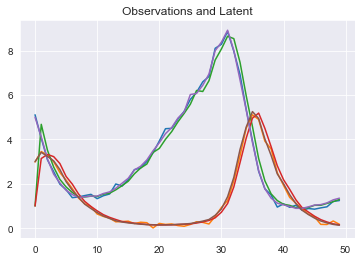

In [6]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent")

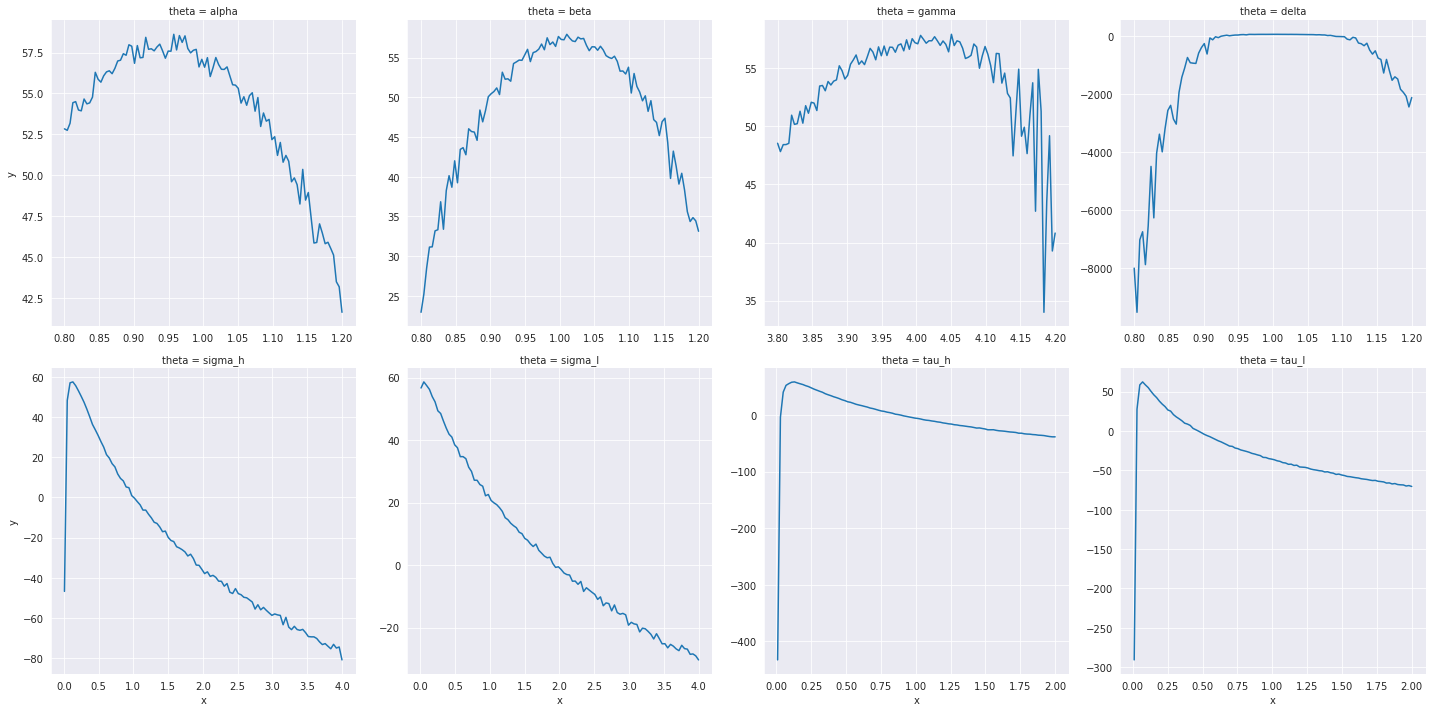

In [8]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [7]:
import optax
from functools import partial
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # First we obtain the gradients of the gradient function with respect to the `grad_fun`.
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    # Updating the params with respect to the mask.
    params_update = jnp.where(mask, params_update, 0)
    # Applying the updates to the parameters except for those that are masked.
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def stoch_opt(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params = update_fn(params, subkey, opt_state)
    return params 
    

def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    """
    Evaluate the bootstrap particle filter estimate of the negative log-likelihood at parameter values \theta. Runs the particle filter for each timestep in y_meas and sums the log-weights for each particle
    Args:
        theta: A `jnp.array` that represents the values of the parameters.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
    Returns:
        Estimate of the negative log-likelihood evaluated at \theta. 
    """
    ret = pf.particle_filter(model, key, y_meas, jnp.exp(theta), n_particles)
    sum_particle_lweights = pf.particle_loglik(ret['logw'])
    return -sum_particle_lweights



def hessian_averaging_alg(optima, key, grad_fun, y_meas, model, iterations=100, n_particles=500):
    hessian_fn = jax.jacfwd(jax.jacrev(grad_fun))
    hess = hessian_fn(optima, key, n_particles=n_particles, y_meas=y_meas, model=model)
    keys = random.split(key, iterations)
    for subkey in keys:
        while(jnp.all(jnp.linalg.eigvals(hess) >= 0)): 
            new_hess = hessian_fn(optima, subkey, n_particles=n_particles, y_meas=y_meas, model=model)
            hess = (hess + new_hess) / 2.0
    return hess 

In [8]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))


/Users/mlysy/miniconda3/envs/jaxenv/lib/python3.8/site-packages/jax/interpreters/xla.py:803: UserWarning: Some donated buffers were not usable: f64[8]{0}.
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/notebooks/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


In [9]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
hess = hessian_fn(params, key, n_particles=1000, y_meas=y_meas, model=lotvol_model)

DeviceArray([ 5.34725795e+05+0.j, -1.68270432e+05+0.j,
             -2.72561831e+04+0.j,  2.24935267e+04+0.j,
              1.11678230e+04+0.j,  6.58036996e+03+0.j,
              1.56724956e+02+0.j,  2.40841914e+03+0.j], dtype=complex128)

In [15]:
(hess_diag, hess_mat) = jnp.linalg.eig(hess)
jnp.linalg.multi_dot([hess_mat, jnp.diag(hess_diag), hess_mat.T]) - hess

DeviceArray([[ 1.74622983e-10+0.j, -2.91038305e-11+0.j,
               1.01863407e-10+0.j, -2.03726813e-10+0.j,
              -2.91038305e-11+0.j,  1.01863407e-10+0.j,
               4.00177669e-11+0.j, -5.09317033e-11+0.j],
             [-2.91038305e-11+0.j, -8.00355338e-11+0.j,
               2.18278728e-11+0.j,  3.63797881e-11+0.j,
              -1.02318154e-12+0.j, -5.09317033e-11+0.j,
              -1.63709046e-11+0.j,  3.63797881e-12+0.j],
             [ 5.82076609e-11+0.j,  1.45519152e-11+0.j,
               2.91038305e-11+0.j, -5.09317033e-11+0.j,
              -1.75077730e-11+0.j,  3.27418093e-11+0.j,
               7.27595761e-12+0.j, -1.81898940e-11+0.j],
             [-5.82076609e-11+0.j,  5.82076609e-11+0.j,
              -2.91038305e-11+0.j,  7.27595761e-11+0.j,
               5.59339242e-11+0.j, -4.72937245e-11+0.j,
              -2.54658516e-11+0.j,  2.91038305e-11+0.j],
             [ 6.36646291e-12+0.j, -1.09139364e-11+0.j,
               8.86757334e-12+0.j, -2.683009

In [21]:
jnp.concatenate((jnp.linalg.solve(hess_mat, params), 1.0/hess_diag))

DeviceArray([-1.23638637e+00+0.j, -5.46332522e-03-0.j,
             -4.60187473e-01-0.j, -1.77946649e-01-0.j,
              9.71301636e-01+0.j,  1.95526631e+00+0.j,
             -3.53189574e+00-0.j,  5.45220859e-02+0.j,
              1.87011737e-06-0.j, -5.94281471e-06-0.j,
             -3.66889230e-05-0.j,  4.44572349e-05-0.j,
              8.95429661e-05-0.j,  1.51967140e-04-0.j,
              6.38060475e-03-0.j,  4.15210119e-04-0.j], dtype=complex128)

In [11]:
hess = hessian_averaging_alg(params, key, particle_neg_loglik, y_meas, lotvol_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print(temp)

False


In [12]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
additive_const = 1e-2
hess = hessian_fn(params, key, n_particles=1000, y_meas=y_meas, model=lotvol_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


Original Hessian estimate is positive semidefinite:  False
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


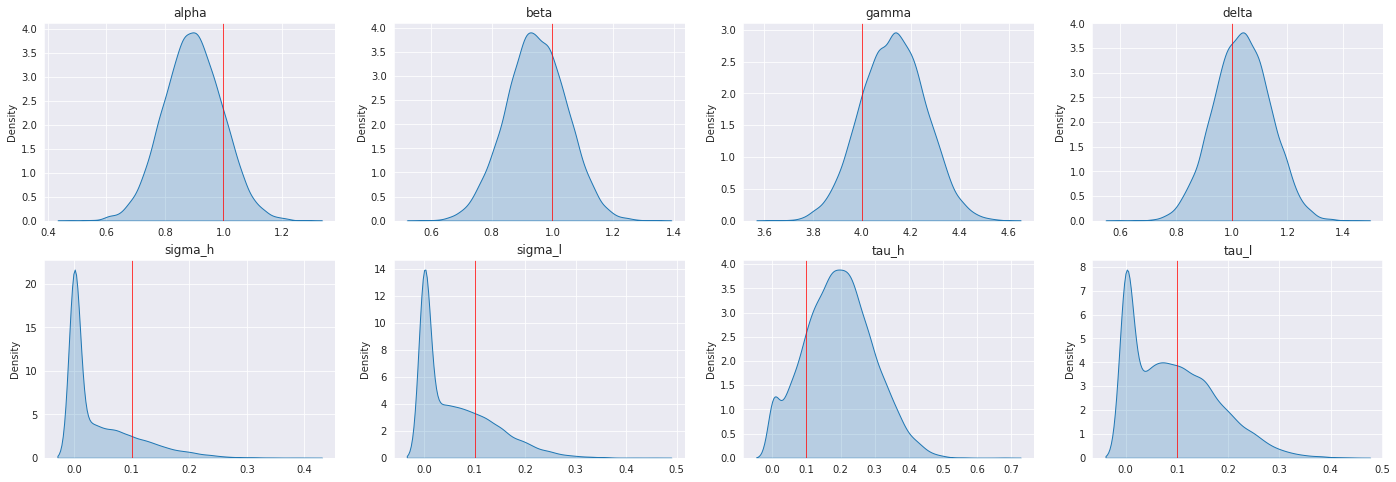

In [18]:
mle_samples = np.array(random.multivariate_normal(key=key, mean=params, cov=var_hat, shape=(10_000, )))
temp = mle_samples[:,4]
temp[temp < 0] = 0.0
mle_samples[:, 4] = temp
temp = mle_samples[:,5]
temp[temp < 0] = 0.0
mle_samples[:, 5] = temp
temp = mle_samples[:,6]
temp[temp < 0] = 0.0
mle_samples[:, 6] = temp
temp = mle_samples[:,7]
temp[temp < 0] = 0.0
mle_samples[:, 7] = temp
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show()

In [16]:
mle_samples.shape

(10000, 8)